DATA602 Final Project


### ***Packages Installation***

In [ ]:
pip install nba_api


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Notes: 

Every time we install the nba api, it returns all nba game data including the most recent data. It keeps updating the data for the latest game.

When built the model, we used the data from the previous seasons as train sets and then used the data from the recent season as test sets. 

In [ ]:
pip install xgboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from nba_api.stats.static import teams
from nba_api.stats.endpoints import leaguegamefinder
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

### ***Data Cleaning and Visualization***

#### ***Data Extracting and cleaning***

In [ ]:
nba_teams = teams.get_teams()
team_names=[team['full_name'] for team in nba_teams]
team_ids=[team['id'] for team in nba_teams]
team_abbrs=[team['abbreviation'] for team in nba_teams]

In [ ]:
all_games=pd.DataFrame()
season_ids=[season for season in range(22011,22023)]
for team_id in team_ids:
  gamefinder = leaguegamefinder.LeagueGameFinder(vs_team_id_nullable=team_id)
  games = gamefinder.get_data_frames()[0]
  games['SEASON_ID']=pd.to_numeric(games['SEASON_ID'])
  for season_id in season_ids:
    all_games=pd.concat([all_games,games[games['SEASON_ID']==season_id]]).dropna()
  all_games=all_games.drop_duplicates(subset=['GAME_ID'])

In [ ]:
all_games['Home'] = all_games['MATCHUP'].str[:3]
all_games['Guest'] = all_games['MATCHUP'].str[-3:]
all_games['WL_Encoded']=LabelEncoder().fit_transform(all_games['WL'])
new_team_abbr=all_games[all_games['SEASON_ID']==22022].TEAM_ABBREVIATION.unique()
all_games=all_games[all_games['TEAM_ABBREVIATION'].isin(new_team_abbr)]
all_games.head(5)

,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,PTS,...,REB,AST,STL,BLK,TOV,PF,PLUS_MINUS,Home,Guest,WL_Encoded
1019,22011,1610612742,DAL,Dallas Mavericks,0021100983,2012-04-26,DAL @ ATL,L,241,89,...,40.0,20,9.0,3,16,11,-17.0,DAL,ATL,0
1020,22011,1610612746,LAC,Los Angeles Clippers,0021100966,2012-04-24,LAC @ ATL,L,240,102,...,35.0,18,9.0,4,14,14,-7.0,LAC,ATL,0
1021,22011,1610612752,NYK,New York Knicks,0021100951,2012-04-22,NYK @ ATL,W,238,113,...,37.0,21,13.0,1,17,21,1.0,NYK,ATL,1
1022,22011,1610612738,BOS,Boston Celtics,0021100938,2012-04-20,BOS @ ATL,L,241,92,...,33.0,18,12.0,1,11,18,-5.0,BOS,ATL,0
1023,22011,1610612765,DET,Detroit Pistons,0021100922,2012-04-18,DET @ ATL,L,241,84,...,52.0,17,4.0,4,14,19,-32.0,DET,ATL,0


In [ ]:
all_games.TEAM_ABBREVIATION.unique()

array(['DAL', 'LAC', 'NYK', 'BOS', 'DET', 'TOR', 'ORL', 'CHA', 'PHI',
       'CHI', 'MIL', 'UTA', 'WAS', 'CLE', 'DEN', 'SAC', 'MIA', 'IND',
       'OKC', 'GSW', 'POR', 'PHX', 'LAL', 'MEM', 'SAS', 'MIN', 'HOU',
       'BKN', 'NOP'], dtype=object)

In [ ]:
all_games.columns

Index(['SEASON_ID', 'TEAM_ID', 'TEAM_ABBREVIATION', 'TEAM_NAME', 'GAME_ID',
       'GAME_DATE', 'MATCHUP', 'WL', 'MIN', 'PTS', 'FGM', 'FGA', 'FG_PCT',
       'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB',
       'REB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PLUS_MINUS', 'Home', 'Guest',
       'WL_Encoded'],
      dtype='object')

#### ***Champ 2nd Half SeasonWin Rate for the Last 10 years***

In [ ]:
champs_records={22011:'DAL',22012:'MIA',22013:'MIA',22014:'SAS',
                22015:'GSW',22016:'CLE',22017:'GSW',
                22018:'GSW',22019:'TOR',22020:'LAL',22021:'MIL'}

In [ ]:
win_rates=dict()
for year,team in champs_records.items():
  champ=all_games[(all_games['Home']==team) | (all_games['Guest']==team)]
  champ=champ[champ['SEASON_ID']==year].drop_duplicates(subset=['GAME_ID'])

  win_rate=round(len(champ[champ['WL_Encoded']==0])/len(champ.WL_Encoded),3)
  win_rates[str(year)[1:len(str(year))]+str(team)]=win_rate


avg_win_rate=sum(list(win_rates.values()))/len(win_rates)

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'winning rate')

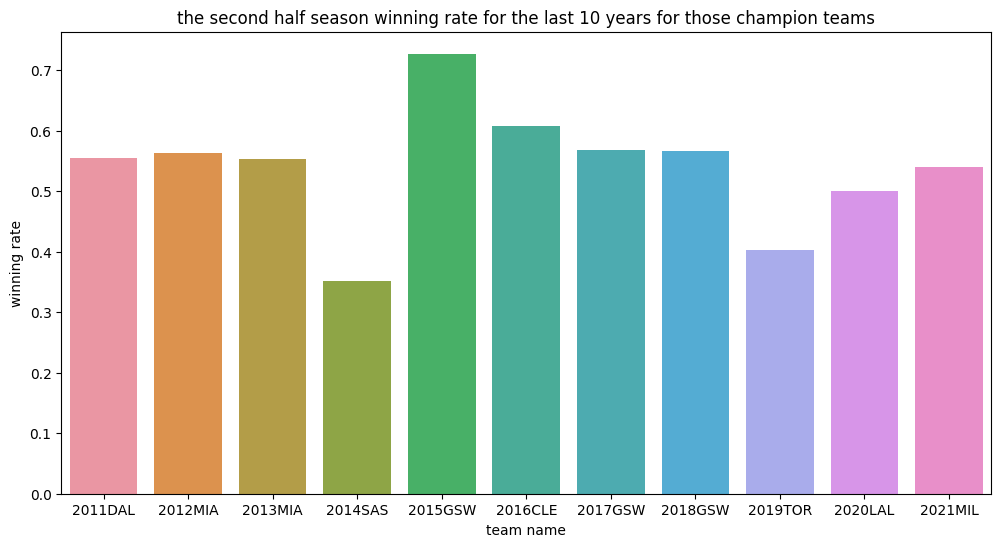

In [ ]:
import matplotlib
import matplotlib.pyplot as plt


matplotlib.rc_file_defaults()

fig, ax1 = plt.subplots(figsize=(12,6))
sns.barplot( list(win_rates.keys()),list(win_rates.values()))
ax1.set_title('the second half season winning rate for the last 10 years for those champion teams')
ax1.set_xlabel("team name")
ax1.set_ylabel("winning rate")


#### ***League Offence Trend***

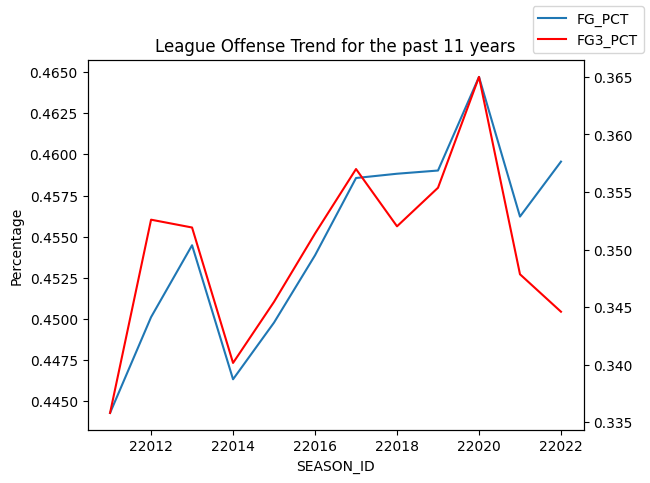

In [ ]:

season=[i for i in range(2011,2023)]
pts=all_games.groupby(['SEASON_ID'])['PTS'].agg('mean').reset_index()
FG_PCT=all_games.groupby(['SEASON_ID'])['FG_PCT'].agg('mean').reset_index()
FT_PCT=all_games.groupby(['SEASON_ID'])['FT_PCT'].agg('mean').reset_index()
FG3_PCT=all_games.groupby(['SEASON_ID'])['FG3_PCT'].agg('mean').reset_index()

all_data=pd.concat([pts,FG_PCT['FG_PCT'],FG3_PCT['FG3_PCT']],axis=1)
ax = all_data.plot(x='SEASON_ID', y="FG_PCT", legend=False)
ax2 = ax.twinx()
all_data.plot(x='SEASON_ID', y="FG3_PCT", ax=ax2, legend=False, color="r")
ax.figure.legend()
ax.set_ylabel("Percentage")
ax.set_title("League Offense Trend for the past 11 years")
plt.show()


***League Average Scores for the Past 10 Year***

In [ ]:
ax=sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})


ax=sns.lineplot(season, y=pts['PTS'], marker='o', sort = False, ax=ax1)
ax.set_title('League Average Scores for the Past 10 Year')

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'League Average Scores for the Past 10 Year')

### ***Model Building*** 

#### ***Correlation***

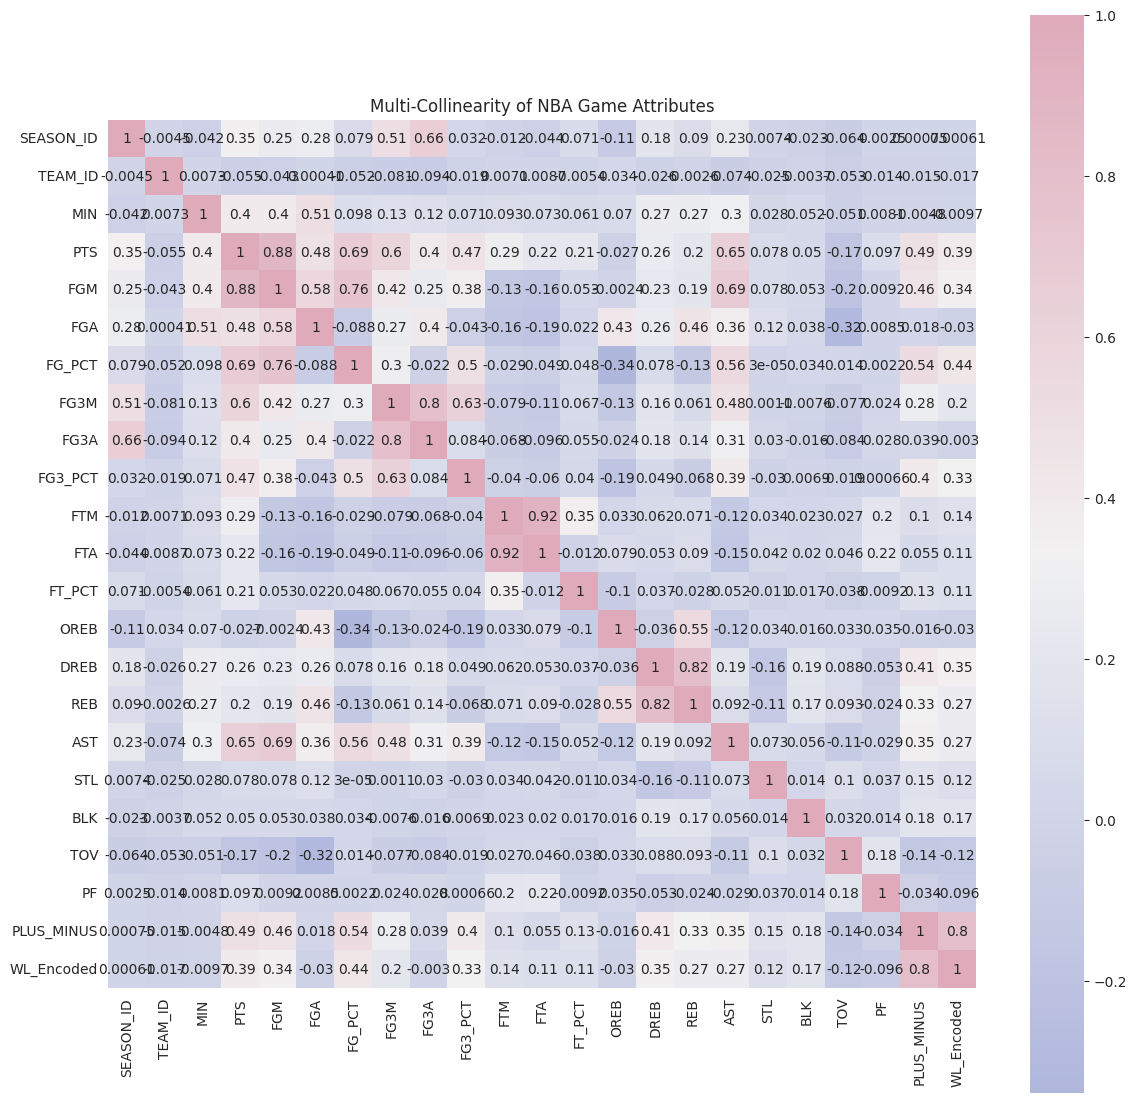

In [ ]:
corr=all_games.corr()

cmap=sns.diverging_palette(260,-10,s=50, l=75, n=6, as_cmap=True)
plt.subplots(figsize=(14,14))
sns.heatmap(corr,cmap=cmap,annot=True, square=True)
plt.title("Multi-Collinearity of NBA Game Attributes")
plt.show()

***Selected Columns***

In [ ]:
select_columns=['PTS','FGM','FG_PCT','FG3_PCT','DREB']

#### ***Logistic Regression***

##### ***Logistic Regression -- Training, Tuning and Validatioin***

In [ ]:
def team_model(data,team_abbr,column):

  # Train data in the previsous 10 season
  df=data[data['TEAM_ABBREVIATION']==team_abbr]
  df_before22=df[df['SEASON_ID']!=22022]
  X=df_before22[column]
  y=df_before22['WL_Encoded']
  clf = LogisticRegression()


  param_grid = {
    'C': [0.1, 1, 10],
    'penalty': ['l1', 'l2'],
}

  grid_search = GridSearchCV(clf, param_grid, cv=3)
  grid_search.fit(X, y)

  clf.C = grid_search.best_params_['C']
  clf.penalty = grid_search.best_params_['penalty']

  clf.fit(X, y)

  #Validate result 
  game_22=df[df['SEASON_ID']==22022]
  game_22['predict_outcome']=clf.predict(game_22[column])


  
  return accuracy_score(game_22['WL_Encoded'], game_22['predict_outcome']),game_22


accuracy_log=dict()
predict_data_LOG=pd.DataFrame()
for team_abbr in new_team_abbr:
    accuracy_log[team_abbr],df=team_model(all_games,team_abbr,select_columns)
    predict_data_LOG=pd.concat([predict_data_LOG,df])

  

/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
9 fits failed out of a total of 18.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
9 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py", line 447, in _check_solver
    raise ValueError(
ValueError: Solver lbf

#####***Output***

In [ ]:
predict_data_LOG

,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,PTS,...,AST,STL,BLK,TOV,PF,PLUS_MINUS,Home,Guest,WL_Encoded,predict_outcome
0,22022,1610612741,CHI,Chicago Bulls,0022200400,2022-12-11,CHI @ ATL,L,264,122,...,28,11.0,6,18,21,-1.0,CHI,ATL,0,1
10,22022,1610612741,CHI,Chicago Bulls,0022200250,2022-11-21,CHI vs. BOS,W,241,121,...,26,10.0,1,11,19,14.0,CHI,BOS,1,1
19,22022,1610612741,CHI,Chicago Bulls,0022200124,2022-11-04,CHI @ BOS,L,240,119,...,21,8.0,5,17,28,-4.0,CHI,BOS,0,1
23,22022,1610612741,CHI,Chicago Bulls,0022200047,2022-10-24,CHI vs. BOS,W,240,120,...,29,4.0,6,13,18,18.0,CHI,BOS,1,1
25,22022,1610612741,CHI,Chicago Bulls,0022200032,2022-10-22,CHI vs. CLE,L,242,96,...,19,12.0,7,10,19,-32.0,CHI,CLE,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8,22022,1610612754,IND,Indiana Pacers,0022200276,2022-11-25,IND vs. BKN,W,241,128,...,28,13.0,4,9,11,11.0,IND,BKN,1,1
21,22022,1610612754,IND,Indiana Pacers,0022200098,2022-10-31,IND @ BKN,L,241,109,...,23,11.0,5,24,24,-7.0,IND,BKN,0,0
22,22022,1610612754,IND,Indiana Pacers,0022200083,2022-10-29,IND @ BKN,W,240,125,...,31,7.0,1,10,25,9.0,IND,BKN,1,1
10,22022,1610612754,IND,Indiana Pacers,0022200249,2022-11-21,IND vs. ORL,W,242,123,...,32,9.0,5,21,23,21.0,IND,ORL,1,1


##### ***Logistic Regression -- Accuracy Score for each team***

In [ ]:
Log_df=pd.DataFrame.from_dict(accuracy_log,orient="index").reset_index()
Log_df = Log_df.rename(columns={"index": "Teams", 0: "Log_Accuracy_Score"})
Log_df

,Teams,Log_Accuracy_Score
0,CHI,0.714286
1,BKN,0.833333
2,NYK,0.500000
3,OKC,0.518519
4,DEN,0.375000
5,ORL,0.764706
6,PHI,0.750000
7,MIA,0.642857
8,HOU,0.625000
9,SAC,0.703704


##### ***Logistic Regression -- Accuracy score visulization***

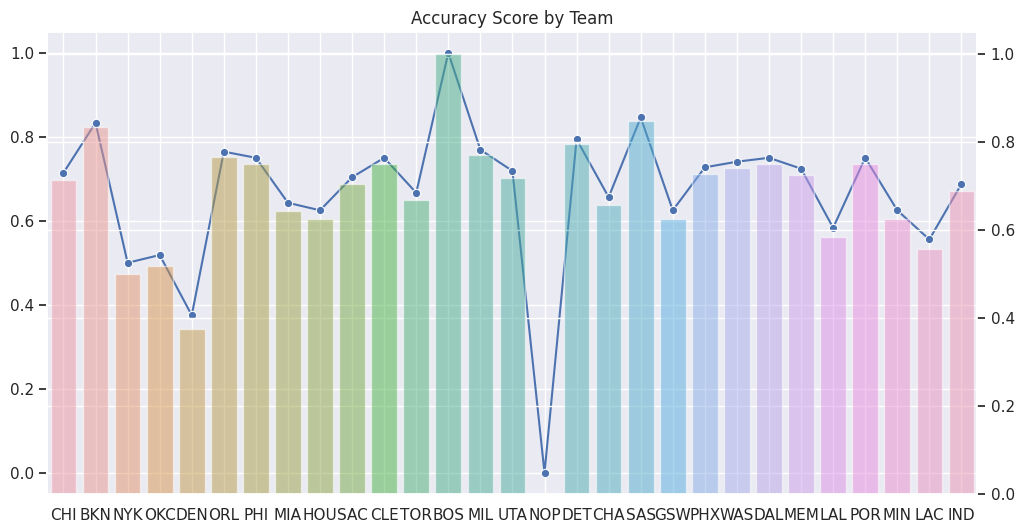

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

matplotlib.rc_file_defaults()
sns.set_theme(style="darkgrid")


ax1 = sns.set_style(style=None, rc=None )

fig, ax1 = plt.subplots(figsize=(12,6))

sns.lineplot(data = list(accuracy_log.values()), marker='o', sort = False, ax=ax1).set(title='Accuracy Score by Team')
ax2 = ax1.twinx()
sns.barplot( x=list(accuracy_log.keys()), y=list(accuracy_log.values()), alpha=0.5, ax=ax2)


##### ***Logistic Regression -- Average Accuracy score***

In [ ]:
avg = Log_df[["Log_Accuracy_Score"]].mean()
avg

Log_Accuracy_Score    0.668866
dtype: float64

#### ***XGboost***

##### ***XBboost -- Training, Tuning and Validatioin***

In [ ]:
def xgb_team_model(data,team_abbr,column):

  # Train data in the previsous 10 season
  df=data[data['TEAM_ABBREVIATION']==team_abbr]
  df_before22=df[df['SEASON_ID']!=22022]
  X=df_before22[column]
  y=df_before22['WL_Encoded']

  param_grid = {
    'n_estimators': [5,10, 100, 1000],
    'max_depth': [5, 10, 15,30],
}
  model = XGBClassifier()
  grid_search = GridSearchCV(model, param_grid, cv=3)
  grid_search.fit(X, y)

  model.n_estimators = grid_search.best_params_['n_estimators']
  model.max_depth = grid_search.best_params_['max_depth']

  model.fit(X, y)

  #Validate result 
  game_22=df[df['SEASON_ID']==22022]
  game_22['predict_outcome']=model.predict(game_22[column])


  
  return accuracy_score(game_22['WL_Encoded'], game_22['predict_outcome']),game_22


accuracy_XGBoost=dict()
predict_data_XGB=pd.DataFrame()
for team_abbr in new_team_abbr:
    accuracy_XGBoost[team_abbr],df=xgb_team_model(all_games,team_abbr,select_columns)
    predict_data_XGB=pd.concat([predict_data_XGB,df])


<ipython-input-27-794af9c369b6>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  game_22['predict_outcome']=model.predict(game_22[column])
<ipython-input-27-794af9c369b6>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  game_22['predict_outcome']=model.predict(game_22[column])
<ipython-input-27-794af9c369b6>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://p

##### ***Output***

In [ ]:
predict_data_XGB.head()

,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,PTS,...,AST,STL,BLK,TOV,PF,PLUS_MINUS,Home,Guest,WL_Encoded,predict_outcome
0,22022,1610612741,CHI,Chicago Bulls,0022200400,2022-12-11,CHI @ ATL,L,264,122,...,28,11.0,6,18,21,-1.0,CHI,ATL,0,0
10,22022,1610612741,CHI,Chicago Bulls,0022200250,2022-11-21,CHI vs. BOS,W,241,121,...,26,10.0,1,11,19,14.0,CHI,BOS,1,1
19,22022,1610612741,CHI,Chicago Bulls,0022200124,2022-11-04,CHI @ BOS,L,240,119,...,21,8.0,5,17,28,-4.0,CHI,BOS,0,1
23,22022,1610612741,CHI,Chicago Bulls,0022200047,2022-10-24,CHI vs. BOS,W,240,120,...,29,4.0,6,13,18,18.0,CHI,BOS,1,1
25,22022,1610612741,CHI,Chicago Bulls,0022200032,2022-10-22,CHI vs. CLE,L,242,96,...,19,12.0,7,10,19,-32.0,CHI,CLE,0,0


##### ***XGBoost -- Accuracy Score for each team***

In [ ]:
XGBoost_df=pd.DataFrame.from_dict(accuracy_XGBoost,orient="index").reset_index()
XGBoost_df = XGBoost_df.rename(columns={"index": "Teams", 0: "XGB_Accuracy_Score"})
XGBoost_df

,Teams,XGB_Accuracy_Score
0,CHI,0.714286
1,BKN,1.000000
2,NYK,0.571429
3,OKC,0.703704
4,DEN,0.375000
5,ORL,0.705882
6,PHI,0.800000
7,MIA,0.714286
8,HOU,0.750000
9,SAC,0.666667


##### ***XGBoost Model -- Accuracy score visulization***

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]),
 <a list of 29 Text major ticklabel objects>)

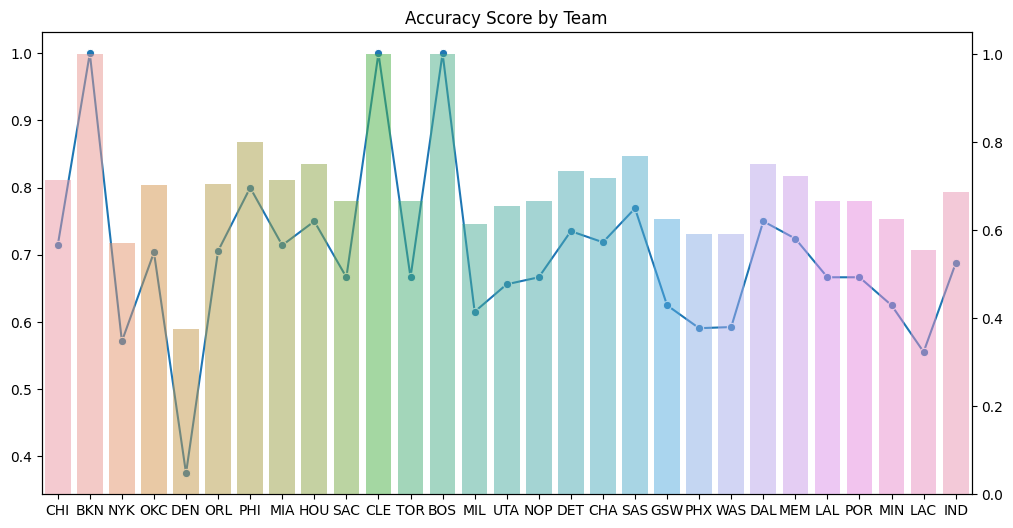

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

matplotlib.rc_file_defaults()
ax1 = sns.set_style(style=None, rc=None )

fig, ax1 = plt.subplots(figsize=(12,6))

sns.lineplot(data = list(accuracy_XGBoost.values()), marker='o', sort = False, ax=ax1).set(title='Accuracy Score by Team')
ax2 = ax1.twinx()
sns.barplot( x=list(accuracy_XGBoost.keys()), y=list(accuracy_XGBoost.values()), alpha=0.5, ax=ax2)
plt.xticks(rotation=45)

##### ***XGBoost -- Average Accuracy score***

In [ ]:
avg = XGBoost_df[["XGB_Accuracy_Score"]].mean()
avg

XGB_Accuracy_Score    0.700466
dtype: float64

### ***Comparison -- Logistic Regression VS XGBoost***

In [ ]:
Comparison=Log_df.merge(XGBoost_df,how='inner')
Comparison=Comparison.append(pd.Series(Comparison[['Log_Accuracy_Score','XGB_Accuracy_Score']].mean(), name="Mean"))
Comparison

,Teams,Log_Accuracy_Score,XGB_Accuracy_Score
0,CHI,0.714286,0.714286
1,BKN,0.833333,1.000000
2,NYK,0.500000,0.571429
3,OKC,0.518519,0.703704
4,DEN,0.375000,0.375000
5,ORL,0.764706,0.705882
6,PHI,0.750000,0.800000
7,MIA,0.642857,0.714286
8,HOU,0.625000,0.750000
9,SAC,0.703704,0.666667
